In [ ]:
# Real scalar boson star or oscillaton example
# see further details in https://github.com/GRChombo/engrenage/wiki/Running-the-oscillaton-example

# restart the kernel to clear past work
# (can also do this manually from the Kernel options above)

# Commented out these 2 lines
#from IPython.core.display import HTML
#HTML("<script>Jupyter.notebook.kernel.restart()</script>")

: 

In [1]:
import sys
print(sys.executable)

import os
os.getcwd()


/apps/leuven/rocky8/skylake/2024a/software/Python/3.12.3-GCCcore-13.3.0/bin/python3


'/vsc-hard-mounts/leuven-user/384/vsc38419/0scillons/source/Notebooks'

In [2]:
# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time
import random
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Modified Gravity
#sys.path.append('/Users/serdaryildiz/Desktop/GRSerdar/engrenage/SGB_Oscillons/source')
#sys.path.append('/Users/serdaryildiz/Desktop/GRSerdar/engrenage/SGB_BR/source')

#cluster
sys.path.append('/user/leuven/384/vsc38419/0scillons/source')




from core.grid import Grid
from core.rhsevolution_MG import *
from core.spacing import *
from core.display import * 
from core.statevector import *
from matter.scalarmatter_MG import *

from bssn.oscillondiagnostic import (get_oscillon_diagnostic,
                                     plot_density_profiles_at_times,
                                     plot_paper_diagnostics)


# This is the one where we solve the constraints with solver in stead of importing data
from initialdata.ModifiedGravityInitialConditions import *

# In these two we import tabulated oscillon initial data
#from initialdata.ModifiedGravityInitialConditions2 import *
#from initialdata.oscillatoninitialconditions_MG import *

from backgrounds.sphericalbackground import *
from bssn.constraintsdiagnostic import *
from bssn.ahfinder import *

# Parameter Selection

In [3]:
####################################################
# CHOOSE SIMULATION PARAMETERS
####################################################

#Mass of scalar field
scalar_mu = 1

# Extra parameter in scalar potential
#selfinteraction = 0.1

#Modified Gravity parameters
lambda_GB = 0.001 # Coupling constant
a = 0.2 # modified gauge parameter
b= 0.4 # # modified gauge parameter
chi0 = 0.15  #S function that slowly turns off the MG terms when getting closer to singularity

# The other option to choose from is 'Linear'
coupling = 'quadratic'

# Initial values scalar field and momentum scalar field
u_val = - 1.10495* 10**(-1)
v_val = 4.2354 * 10**(-2)

# PERTURBATION
#perturbation_amplitude = 1e-1 # set to zero for no perturbation
perturbation_amplitude = 10**(-2) # set to zero for no perturbation
perturbation_width = 10

# Grouping parameters
ppp = (lambda_GB, a, b, chi0, coupling)

# Resolution selection

In [4]:
####################################################
# CHOOSE SIMULATION RESOLUTION
####################################################

my_matter = ScalarMatter(scalar_mu)
my_state_vector = StateVector(my_matter)

"""
# HIGHER RESOLUTION
r_max = 96.0 # outer edge of the grid (including ghosts)
min_dr = 1 / 16
max_dr = 2
"""


# LOWER RESOLUTION
r_max = 150 # outer edge of the grid (including ghosts)
min_dr = 1 / 4
max_dr = 2


"""
# LOWER RESOLUTION
r_max = 64
min_dr = 1 / 4
max_dr = 2
"""

# CubicSpacing
params = CubicSpacing.get_parameters(r_max, min_dr, max_dr)
spacing = CubicSpacing(**params)

# Grid
grid = Grid(spacing, my_state_vector)
r = grid.r
num_points = r.size
background = FlatSphericalBackground(r)

# Initial Data Selection

In [5]:
#ID solver from MGIC
initial_state = get_initial_state(grid, background, ppp, my_matter, perturbation_amplitude, perturbation_width, scalar_mu, u_val, v_val )

# ID solver from oscillaton_MG.py
#initial_state = get_initial_state(grid, background, (1e-1,10))

#ID solver from MGIC2
#initial_state = get_initial_state(grid, background, (5, a, b, chi0, "quadratic"), my_matter, 0, 5, scalar_mu )


#unpackage the vector for readability
(initial_phi, initial_hrr, initial_htt, initial_hpp, 
 initial_K, initial_arr, initial_att, initial_app, 
 initial_lambdar, initial_shiftr, initial_br, initial_lapse,
 initial_u, initial_v) = np.array_split(initial_state, grid.NUM_VARS)

error is:  0.009887499360326641  after iter:  12


## With perturbation

In [6]:
import matplotlib.pyplot as plt
couplings = ["quadratic"]
time = 200

lambda_vals = [0]
#perturbations = [1.51 * 10**-2] 
#R_bump = [6.82]

perturbations = [1e-4] 
R_bump = [2.705]

ALL_SOLS = []
ALL_BHM = []

#for i, perturbation in enumerate(perturbations):
for l, lambda_GB in enumerate(lambda_vals):
    for k, width in enumerate(R_bump):
        for j, perturbation in enumerate(perturbations):

            # This is the modified gravity solver intitial data:
            initial_state = get_initial_state(grid, background, (lambda_GB, a, b, chi0, couplings[0]), my_matter, perturbation, width, scalar_mu, u_val, v_val )

            # This is the oscillaton initial data from katy example:
            #initial_state = get_initial_state(grid, background, (perturbations[0],R_bump[0]))

            # The new oscillon ID solver
            #initial_state = get_initial_state(grid, background, (lambda_vals[j], a, b, chi0, "quadratic"), my_matter, perturbations[0], R_bump, scalar_mu )



            # time settings
            T = time
            #num_points_t = 101
            num_points_t = 1000
            dt = T/num_points_t
            t = np.linspace(0, T-dt, num_points_t)

            # solve
            with tqdm(total=1000, unit="‰") as progress_bar:
                dense_solution = solve_ivp(
                    get_rhs, [0,T], initial_state,
                    args=(grid, background, my_matter, progress_bar, [0, T/1000], a, b, lambda_GB, couplings[0]),
                    max_step=0.4 * min_dr,
                    method='RK45',
                    dense_output=True
                )

            solution = dense_solution.sol(t).T

            # diagnostics
            #omega, ah_radius, bh_mass = get_horizon_diagnostics(solution, t, grid, background, my_matter)

            ALL_SOLS.append(solution)
            #ALL_BHM.append(bh_mass)
            ## Start plotting

            

error is:  0.00032812061195929844  after iter:  1


  0%|          | 0/1000 [00:00<?, ?‰/s]

## Without perturbation

In [7]:
#EXTRA WITHOUT perturbation
import matplotlib.pyplot as plt
couplings = ["quadratic"]
time = 200

lambda_vals = [0]
perturbations = [0] 
R_bump = [1]

ALL_SOLS2 = []
ALL_BHM = []

#for i, perturbation in enumerate(perturbations):
for l, lambda_GB in enumerate(lambda_vals):
    for k, width in enumerate(R_bump):
        for j, perturbation in enumerate(perturbations):

            # This is the modified gravity solver intitial data:
            initial_state = get_initial_state(grid, background, (lambda_GB, a, b, chi0, couplings[0]), my_matter, perturbation, width, scalar_mu, u_val, v_val )

            # This is the oscillaton initial data from katy example:
            #initial_state = get_initial_state(grid, background, (perturbations[0],R_bump[0]))

            # The new oscillon ID solver
            #initial_state = get_initial_state(grid, background, (lambda_vals[j], a, b, chi0, "quadratic"), my_matter, perturbations[0], R_bump, scalar_mu )



            # time settings
            T = time
            #num_points_t = 101
            num_points_t = 1000
            dt = T/num_points_t
            t = np.linspace(0, T-dt, num_points_t)

            # solve
            with tqdm(total=1000, unit="‰") as progress_bar:
                dense_solution = solve_ivp(
                    get_rhs, [0,T], initial_state,
                    args=(grid, background, my_matter, progress_bar, [0, T/1000], a, b, lambda_GB, couplings[0]),
                    max_step=0.4 * min_dr,
                    method='RK45',
                    dense_output=True
                )

            solution2 = dense_solution.sol(t).T

            # diagnostics
            #omega, ah_radius, bh_mass = get_horizon_diagnostics(solution, t, grid, background, my_matter)

            ALL_SOLS2.append(solution2)
            #ALL_BHM.append(bh_mass)
            ## Start plotting

            

error is:  1.7025053792287383e-16  after iter:  1


  0%|          | 0/1000 [00:00<?, ?‰/s]

In [8]:
print("Magnitude of the Gauss bonnet term: ", LGB[-1])
print("Mean of magnitude of the Gauss bonnet term: ", np.mean(LGB[-1]))

Magnitude of the Gauss bonnet term:  [ 9.79109279e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.79109278e-09
  9.79109278e-09  9.79109278e-09  9.79109278e-09  9.7

# Evolution over time 

0.62


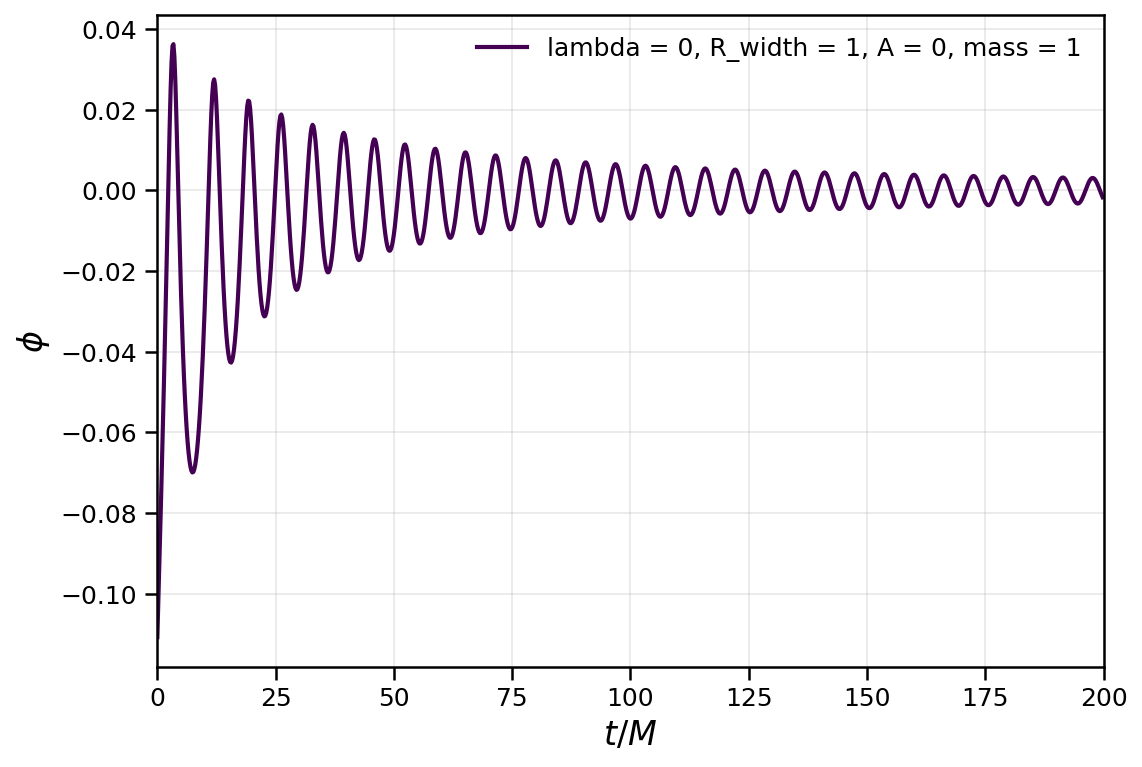

In [9]:
object = 12  # as you had

# --- High-quality global settings ---
plt.rcParams.update({
    "figure.dpi": 150,        # on-screen sharpness
    "savefig.dpi": 300,       # export resolution for PNG
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

cmap = plt.get_cmap("viridis")
cmap2 = plt.get_cmap("plasma")  # if you want a second colormap later
norm = plt.Normalize(0, len(ALL_SOLS) - 1)
linestyles = ['-', '--', '-.', ':']   # will repeat via modulo

# --- Figure / axes creation with nice layout ---
fig, ax = plt.subplots(figsize=(7.5, 5), constrained_layout=True)

for i in range(len(ALL_SOLS)):
    color = cmap(norm(i))

    idx = NUM_GHOSTS + 2
    r_i = np.round(r[idx], 2)
    print(r_i)
    var1_of_t = ALL_SOLS[i][:, object * num_points + idx]

    # use modulo so we don't run out of linestyles
    ax.plot(
        t,
        var1_of_t,
        linestyle=linestyles[i % len(linestyles)],
        color=color,
        lw=2.0,label = "lambda = " + str(lambda_GB) + ", R_width = " + str(width) + ", A = "+str(perturbation)+ ", mass = "+ str(scalar_mu))

ax.set_xlabel(r"$t/M$")
ax.set_ylabel(r"$\phi$")
ax.set_xlim(-0.1, T)

ax.legend(frameon=False, loc="best")
ax.grid(True, alpha=0.3)

# thicker ticks and spines
ax.tick_params(width=1.2, length=6)
for s in ax.spines.values():
    s.set_linewidth(1.2)

# Optional: high-quality exports
# fig.savefig("MultiScalarProfiles.pdf", bbox_inches="tight")        # vector
# fig.savefig("MultiScalarProfiles.png", dpi=300, bbox_inches="tight")
# fig.savefig("MultiScalarProfiles.svg", bbox_inches="tight")

plt.show()

# Radial Profile

## perturbation

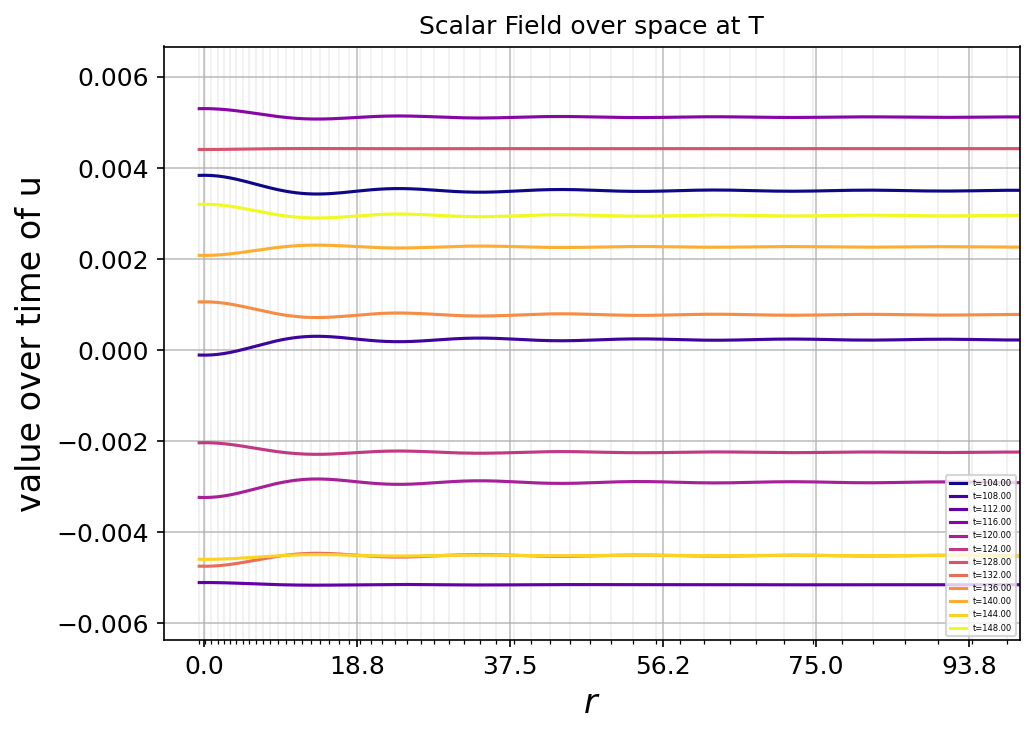

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Single plot
fig, ax = plt.subplots(figsize=(7, 5))

var = my_matter.idx_u

# Select the time slices you want to plot
times = [(i, t_i) for i, t_i in enumerate(t) if 100< t_i < 150 and i % 20 == 0]

# Colormap (plasma)
colors = plt.cm.plasma(np.linspace(0, 1, len(times)))

# Plot all selected time slices
for color, (i, t_i) in zip(colors, times):
    f_t = solution[i, var * num_points:(var + 1) * num_points]
    
    ax.plot(r, f_t, label=f"t={t_i:.2f}", color=color)

# Labels and layout
ax.set_title('Scalar Field over space at T')
ax.set_xlabel('r')
ax.set_ylabel('value over time of ' + my_state_vector.VARIABLE_NAMES[var])
ax.legend(loc=4, fontsize=4)
set_grid_on_ax(ax, r)
ax.set_xlim(-5, 100.0)

plt.tight_layout()
plt.show()


## No perturbation

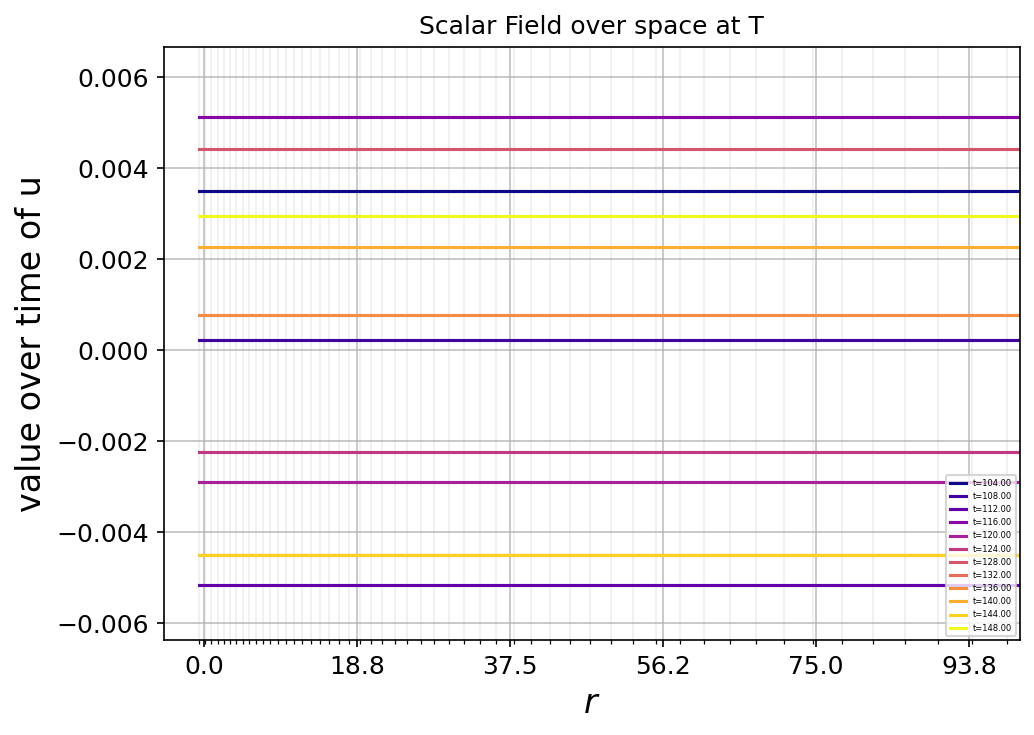

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Single plot
fig, ax = plt.subplots(figsize=(7, 5))

var = my_matter.idx_u

# Select the time slices you want to plot
times = [(i, t_i) for i, t_i in enumerate(t) if 100< t_i < 150 and i % 20 == 0]

# Colormap (plasma)
colors = plt.cm.plasma(np.linspace(0, 1, len(times)))

# Plot all selected time slices
for color, (i, t_i) in zip(colors, times):
    f_t = solution2[i, var * num_points:(var + 1) * num_points]
    
    ax.plot(r, f_t, label=f"t={t_i:.2f}", color=color)

# Labels and layout
ax.set_title('Scalar Field over space at T')
ax.set_xlabel('r')
ax.set_ylabel('value over time of ' + my_state_vector.VARIABLE_NAMES[var])
ax.legend(loc=4, fontsize=4)
set_grid_on_ax(ax, r)
ax.set_xlim(-5, 100.0)

plt.tight_layout()
plt.show()


# Time evolution with background oscillation removed

0.37


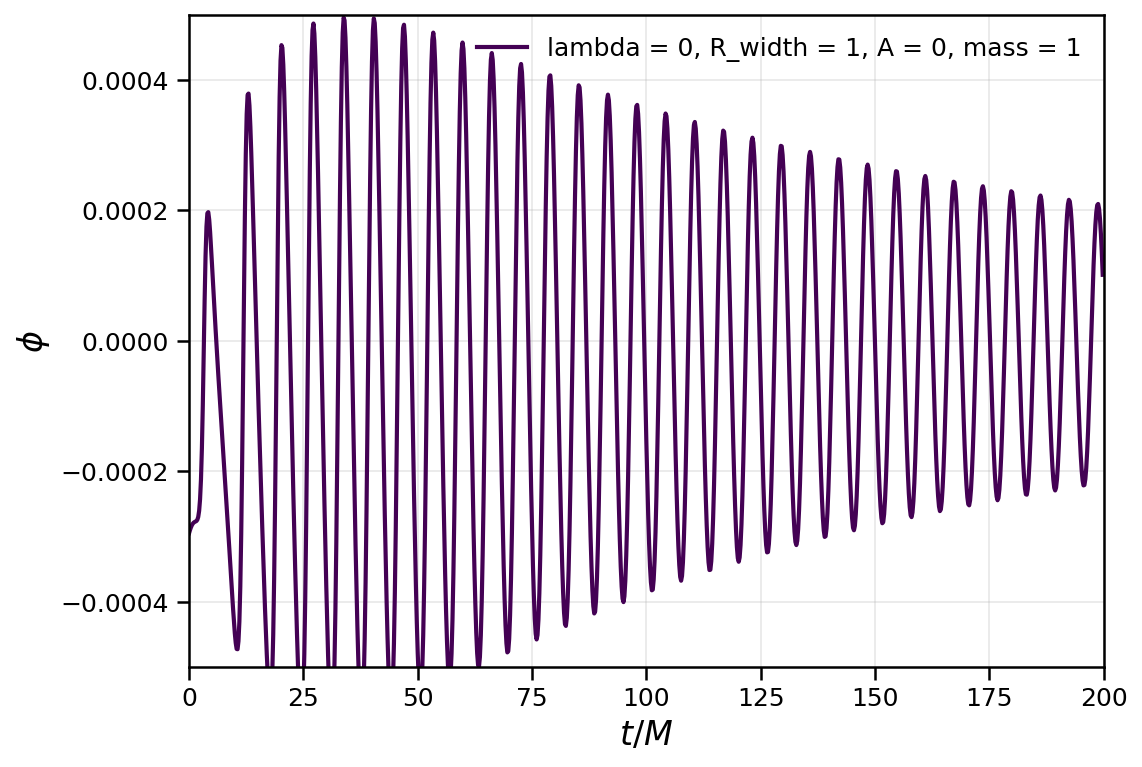

In [12]:
object = 12  # as you had

# --- High-quality global settings ---
plt.rcParams.update({
    "figure.dpi": 150,        # on-screen sharpness
    "savefig.dpi": 300,       # export resolution for PNG
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

cmap = plt.get_cmap("viridis")
cmap2 = plt.get_cmap("plasma")  # if you want a second colormap later
norm = plt.Normalize(0, len(ALL_SOLS) - 1)
linestyles = ['-', '--', '-.', ':']   # will repeat via modulo

# --- Figure / axes creation with nice layout ---
fig, ax = plt.subplots(figsize=(7.5, 5), constrained_layout=True)

for i in range(len(ALL_SOLS)):
    color = cmap(norm(i))

    idx = NUM_GHOSTS + 1
    r_i = np.round(r[idx], 2)
    print(r_i)
    var1_of_t_perturbed = ALL_SOLS[i][:, object * num_points + idx]
    var1_of_t_background = ALL_SOLS2[i][:, object * num_points + idx]
    
    var1_of_t = var1_of_t_perturbed - var1_of_t_background

    # use modulo so we don't run out of linestyles
    ax.plot(
        t,
        var1_of_t,
        linestyle=linestyles[i % len(linestyles)],
        color=color,
        lw=2.0,label = "lambda = " + str(lambda_GB) + ", R_width = " + str(width) + ", A = "+str(perturbation)+ ", mass = "+ str(scalar_mu))

ax.axhline(y=0.0025, linestyle="--", linewidth=1.5)
ax.axhline(y=-0.0025, linestyle="--", linewidth=1.5)    

ax.set_xlabel(r"$t/M$")
ax.set_ylabel(r"$\phi$")
ax.set_xlim(-0.1, T)
ax.set_ylim(-0.0005, 0.0005)

ax.legend(frameon=False, loc="best")
ax.grid(True, alpha=0.3)

# thicker ticks and spines
ax.tick_params(width=1.2, length=6)
for s in ax.spines.values():
    s.set_linewidth(1.2)

# Optional: high-quality exports
# fig.savefig("MultiScalarProfiles.pdf", bbox_inches="tight")        # vector
# fig.savefig("MultiScalarProfiles.png", dpi=300, bbox_inches="tight")
# fig.savefig("MultiScalarProfiles.svg", bbox_inches="tight")

plt.show()

## Resonance Diagnostic

# Radial profile with background removed

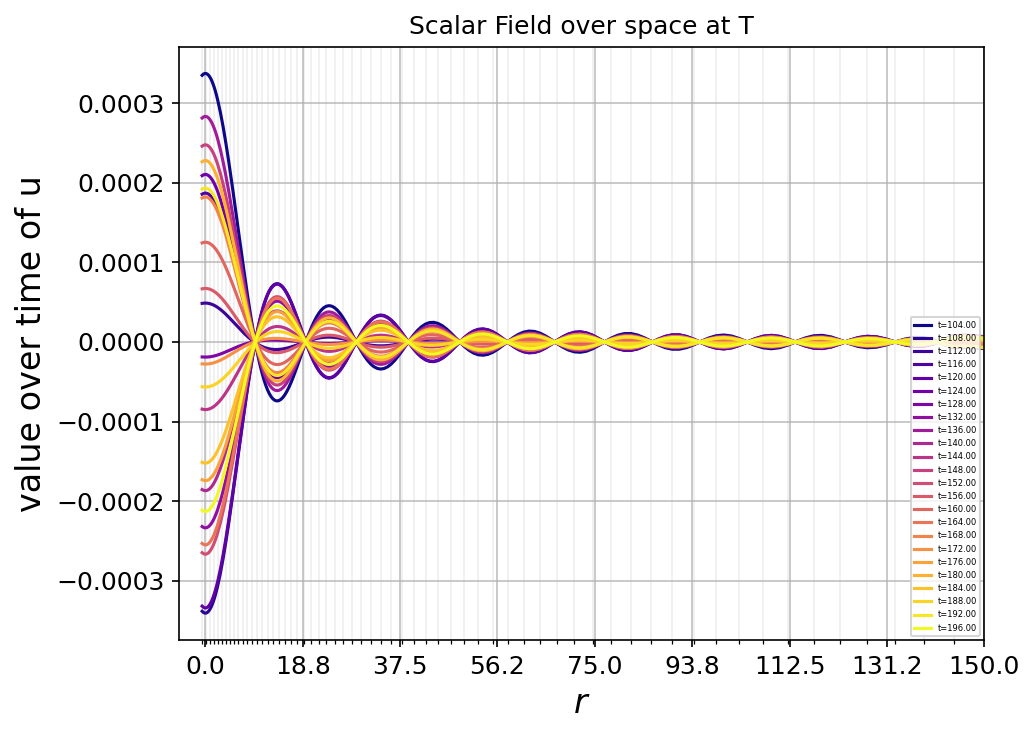

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Single plot
fig, ax = plt.subplots(figsize=(7, 5))

var = my_matter.idx_u

# Select the time slices you want to plot
times = [(i, t_i) for i, t_i in enumerate(t) if 100< t_i < 200 and i % 20 == 0]

# Colormap (plasma)
colors = plt.cm.plasma(np.linspace(0, 1, len(times)))

# Plot all selected time slices
for color, (i, t_i) in zip(colors, times):
    f_t_1 = solution[i, var * num_points:(var + 1) * num_points]
    f_t_2 = solution2[i, var * num_points:(var + 1) * num_points]
    
    f_t = f_t_1 - f_t_2
    
    ax.plot(r, f_t, label=f"t={t_i:.2f}", color=color)

# Labels and layout
ax.set_title('Scalar Field over space at T')
ax.set_xlabel('r')
ax.set_ylabel('value over time of ' + my_state_vector.VARIABLE_NAMES[var])
ax.legend(loc=4, fontsize=4)
set_grid_on_ax(ax, r)
ax.set_xlim(-5, 150.0)

plt.tight_layout()
plt.show()


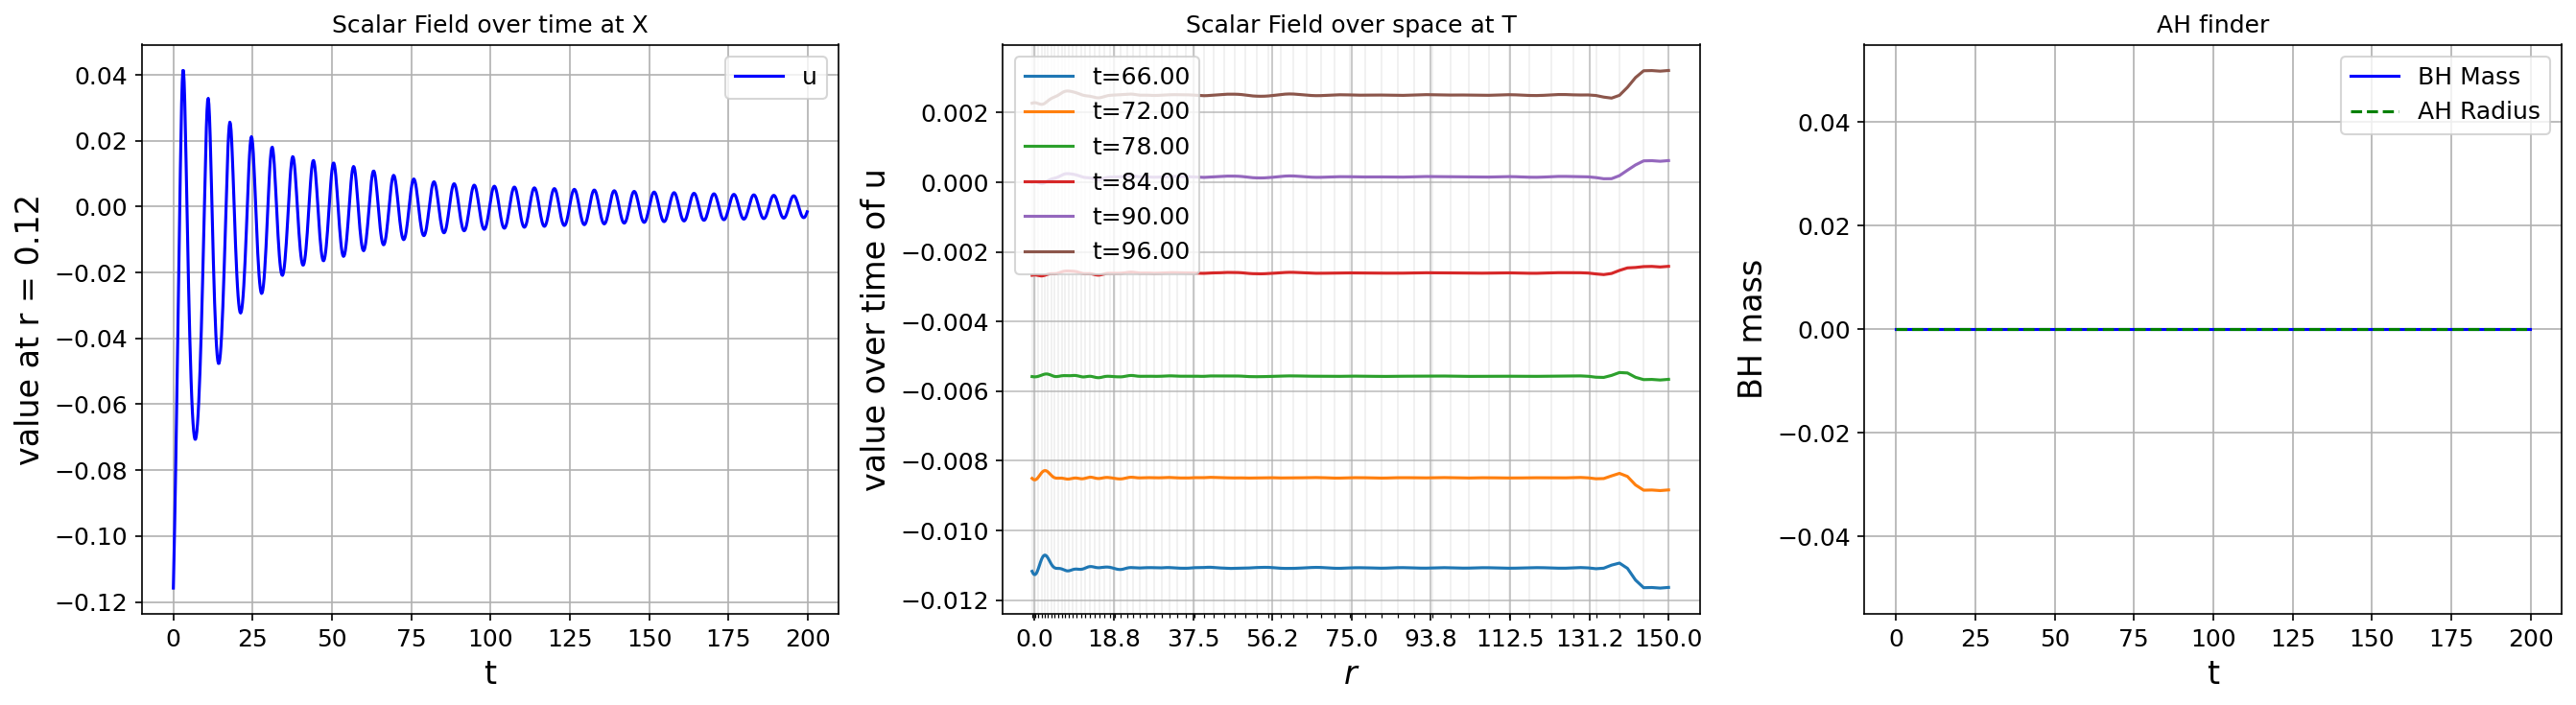

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---------- (1) Evolution over time at fixed r ----------
ax = axes[0]
var1 = my_matter.idx_u
idx = NUM_GHOSTS 
r_i = np.round(r[idx], 2)
var1_of_t = solution[:, var1 * num_points + idx]
ax.plot(t, var1_of_t, 'b-', label=my_state_vector.VARIABLE_NAMES[var1])
ax.set_title('Scalar Field over time at X')
ax.set_xlabel('t')
ax.set_ylabel(f'value at r = {r_i}')
ax.legend(loc='best')
ax.grid(True)

# ---------- (2) Profile evolution over r at different times ----------
ax = axes[1]
var = my_matter.idx_u
for i, t_i in enumerate(t):
    if (60< t_i < 100) and (i % 30 == 0):
        labelt = f"t={t_i:.2f}"
        f_t = solution[i, var * num_points:(var + 1) * num_points]
        ax.plot(r, f_t, label=labelt)

ax.set_title('Scalar Field over space at T')
ax.set_xlabel('r')
ax.set_ylabel('value over time of ' + my_state_vector.VARIABLE_NAMES[var])
ax.legend(loc=2)
set_grid_on_ax(ax, r)
# ax.set_ylim(-0.001, 0.001)

# ---------- (3) Black hole mass and horizon radius ----------
ax = axes[2]
omega, ah_radius, bh_mass = get_horizon_diagnostics(solution, t, grid, background, my_matter)
ax.set_title('AH finder')
ax.plot(t, bh_mass, 'b-', label="BH Mass")
ax.plot(t, ah_radius, 'g--', label="AH Radius")
ax.set_xlabel('t')
ax.set_ylabel('BH mass')
ax.legend(loc='best')
ax.grid(True)
# ax.set_ylim(-0.1, 1.3)

# ---------- Final layout ----------
plt.tight_layout()
plt.show()


# Comparison Against fixed background equation

<>:52: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2274053/3329941620.py:52: SyntaxWarning: invalid escape sequence '\p'
  """


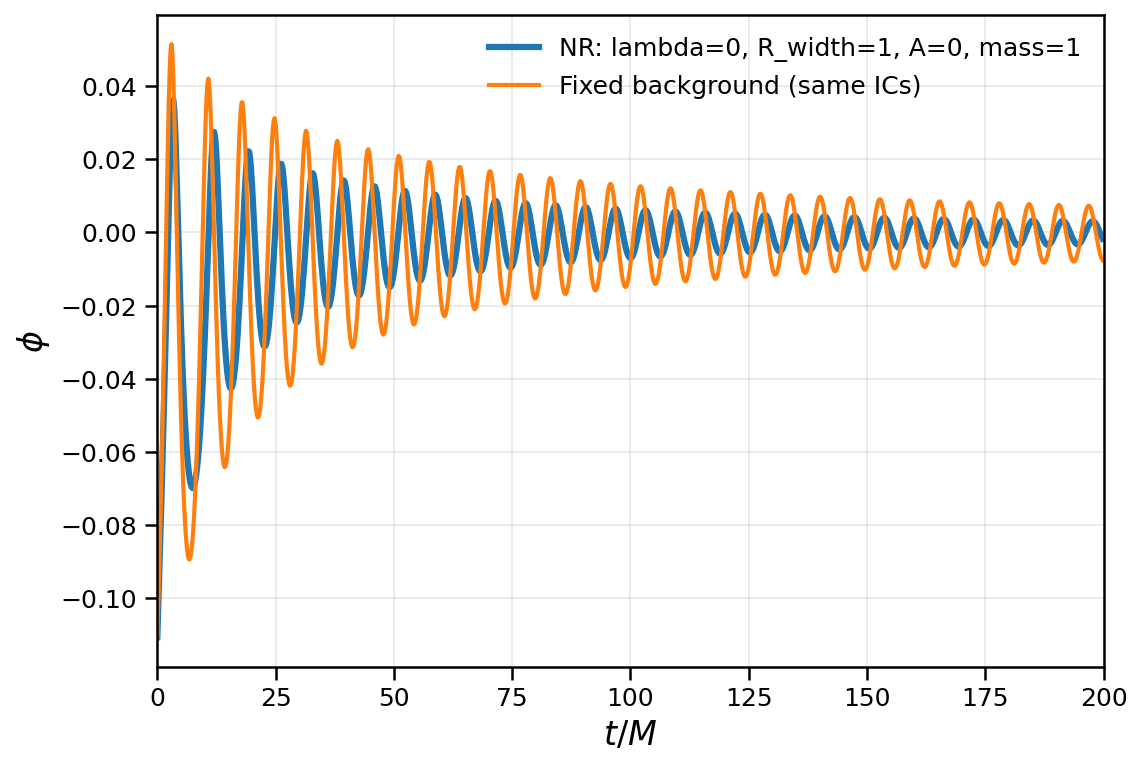

In [14]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Potential parameters
m = 1.0
mu = 0.1

def V(phi):
    # V(phi) = (m^2 mu^2 / 2) * (1 - exp(phi/mu))^2
    return 0.5 * (m**2) * (mu**2) * (1.0 - np.exp(phi / mu))**2

def dV_dphi(phi):
    # dV/dphi = m^2 * mu * exp(phi/mu) * (exp(phi/mu) - 1)
    x = np.exp(phi / mu)
    return (m**2) * mu * x * (x - 1.0)

def rho_scalar(phi, phidot):
    # Energy density of a homogeneous scalar field (in units where 8πG = 1):
    # rho = 1/2 phidot^2 + V(phi)
    return 0.5 * phidot**2 + V(phi)

def hubble_from_rho(rho):
    # Your definition: H0 = sqrt(mean(rho)/3). If rho is a scalar, mean(rho)=rho.
    # If rho is an array, np.mean does the spatial average.
    return np.sqrt(np.mean(rho) / 3.0)

def rhs(t, y):
    # y = [phi, phidot]
    phi, phidot = y

    rho = rho_scalar(phi, phidot)
    H0 = hubble_from_rho(rho)

    phiddot = -3.0 * H0 * phidot - dV_dphi(phi)  # φ¨ + 3Hφ˙ + V_φ = 0
    return [phidot, phiddot]

def integrate_phi(phi0=0.0, phidot0=0.0, t0=0.0, t1=50.0, npts=1000):
    t_eval = np.linspace(t0, t1, npts)
    sol = solve_ivp(
        fun=rhs,
        t_span=(t0, t1),
        y0=[phi0, phidot0],
        t_eval=t_eval,
        method="RK45",
        rtol=1e-9,
        atol=1e-12,
    )
    if not sol.success:
        raise RuntimeError(sol.message)
    return sol.t, sol.y[0], sol.y[1]
"""
if __name__ == "__main__":
    # Initial conditions
    phi0 = - 1.3 * 10**(-1)
    phidot0 = 0.0

    t, phi, phidot = integrate_phi(phi0=phi0, phidot0=phidot0, t1=100.0)

    # Derived quantities
    rho = rho_scalar(phi, phidot)
    H = np.sqrt(rho / 3.0)  # same as hubble_from_rho(rho) pointwise for scalar rho

    plt.figure()
    plt.plot(t, phi)
    plt.xlabel("t")
    plt.ylabel(r"$\phi(t)$")
    plt.tight_layout()

    plt.figure()
    plt.plot(t, phidot)
    plt.xlabel("t")
    plt.ylabel(r"$\dot{\phi}(t)$")
    plt.tight_layout()

    plt.figure()
    plt.plot(t, rho)
    plt.xlabel("t")
    plt.ylabel(r"$\rho(t)$")
    plt.tight_layout()

    plt.figure()
    plt.plot(t, H)
    plt.xlabel("t")
    plt.ylabel(r"$H(t)$")
    plt.tight_layout()
    plt.show()
"""

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# -----------------------------
# Linear homogeneous scalar ODE
# -----------------------------
m = 1.0
mu = 0.1

def V(phi):
    return 0.5 * (m**2) * (mu**2) * (1.0 - np.exp(phi / mu))**2

def dV_dphi(phi):
    x = np.exp(phi / mu)
    return (m**2) * mu * x * (x - 1.0)

def rho_scalar(phi, phidot):
    return 0.5 * phidot**2 + V(phi)

def hubble_from_rho(rho):
    # Your definition: H0 = sqrt(mean(rho)/3); for scalar rho, mean(rho)=rho
    return np.sqrt(np.mean(rho) / 3.0)

def rhs_linear(t, y):
    phi, phidot = y
    rho = rho_scalar(phi, phidot)
    H0 = hubble_from_rho(rho)
    phiddot = -3.0 * H0 * phidot - dV_dphi(phi)
    return [phidot, phiddot]

def solve_linear_on_grid(t_grid, phi0, phidot0):
    sol = solve_ivp(
        rhs_linear,
        (t_grid[0], t_grid[-1]),
        [phi0, phidot0],
        t_eval=t_grid,
        method="RK45",
        rtol=1e-9,
        atol=1e-12,
    )
    if not sol.success:
        raise RuntimeError(sol.message)
    return sol.y[0], sol.y[1]


# -----------------------------
# Your plotting style settings
# -----------------------------
object = 12  # as you had

plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
})

cmap = plt.get_cmap("viridis")
cmap2 = plt.get_cmap("plasma")
norm = plt.Normalize(0, len(ALL_SOLS) - 1)
linestyles = ['-', '--', '-.', ':']

fig, ax = plt.subplots(figsize=(7.5, 5), constrained_layout=True)

# -------------------------------------------------------
# 1) Plot FULL NR curves (your existing loop) on the axis
# -------------------------------------------------------
for i in range(len(ALL_SOLS)):
    color = cmap(norm(i))

    idx = NUM_GHOSTS + 2
    var1_of_t = ALL_SOLS[i][:, object * num_points + idx]  # this is your NR phi(t)

    ax.plot(
        t,
        var1_of_t,
        linestyle=linestyles[i % len(linestyles)],
        color="tab:blue",
        lw=3.0,
        label="NR: " + "lambda=" + str(lambda_GB) + ", R_width=" + str(width)
              + ", A=" + str(perturbation) + ", mass=" + str(scalar_mu)
    )

# -------------------------------------------------------------------
# 2) Solve the linear ODE on the SAME time grid and plot on same axis
#    Choose ICs from the NR curve you want to compare against.
#    Here I use the first NR run (i=0) at the same index as above.
# -------------------------------------------------------------------
i_ref = 0
idx = NUM_GHOSTS + 2
phi_nr_ref = ALL_SOLS[i_ref][:, object * num_points + idx]

# estimate phidot0 from the first two time points (robust enough for comparison)
phi0_lin = float(phi_nr_ref[0])
phidot0_lin = float((phi_nr_ref[1] - phi_nr_ref[0]) / (t[1] - t[0]))

phi_lin, phidot_lin = solve_linear_on_grid(t, phi0_lin, phidot0_lin)

ax.plot(
    t,
    phi_lin,
    color="tab:orange",
    lw=2.0,
    linestyle="-",
    label="Fixed background (same ICs)"
)

# -----------------------------
# Cosmetics
# -----------------------------
ax.set_xlabel(r"$t/M$")
ax.set_ylabel(r"$\phi$")
ax.set_xlim(-0.1, T)

ax.legend(frameon=False, loc="best")
ax.grid(True, alpha=0.3)

ax.tick_params(width=1.2, length=6)
for s in ax.spines.values():
    s.set_linewidth(1.2)

plt.show()


# Diagnotsic Tool

In [15]:
# ==== OSCILLON DIAGNOSTIC  (arXiv:2304.01673 style) ====
# Uses the FULL solution (not background-subtracted) so that
# physical quantities (rho, M, C, ...) are meaningful.

import numpy as np
import matplotlib.pyplot as plt

# ---- PARAMETERS (same MG params as your run) ----
params = (lambda_GB, a, b, chi0, coupling)
i = 0  # index into ALL_SOLS list — change as needed

# ---- RUN DIAGNOSTIC on the full (perturbed) solution ----
osc = get_oscillon_diagnostic(
    ALL_SOLS[i],       # full evolution state
    t,                 # time array
    grid,
    background,
    my_matter,
    params,
    surface_threshold=0.05,   # oscillon surface = 5 % of rho_c  (paper Sec.II-C)
)

# ---- QUICK ACCESS TO RESULTS ----
print("Available keys:", osc.keys())

delta_c     = osc["delta_c"]
compactness = osc["C"]
mass        = osc["M"]
radius      = osc["R"]
rho_bar     = osc["rho_bar"]
rho_c       = osc["rho_c"]
scale_fac   = osc["a"]

Available keys: dict_keys(['t', 'r', 'rho', 'rho_c', 'rho_bar', 'delta_c', 'a', 'M', 'V_proper', 'R', 'C'])


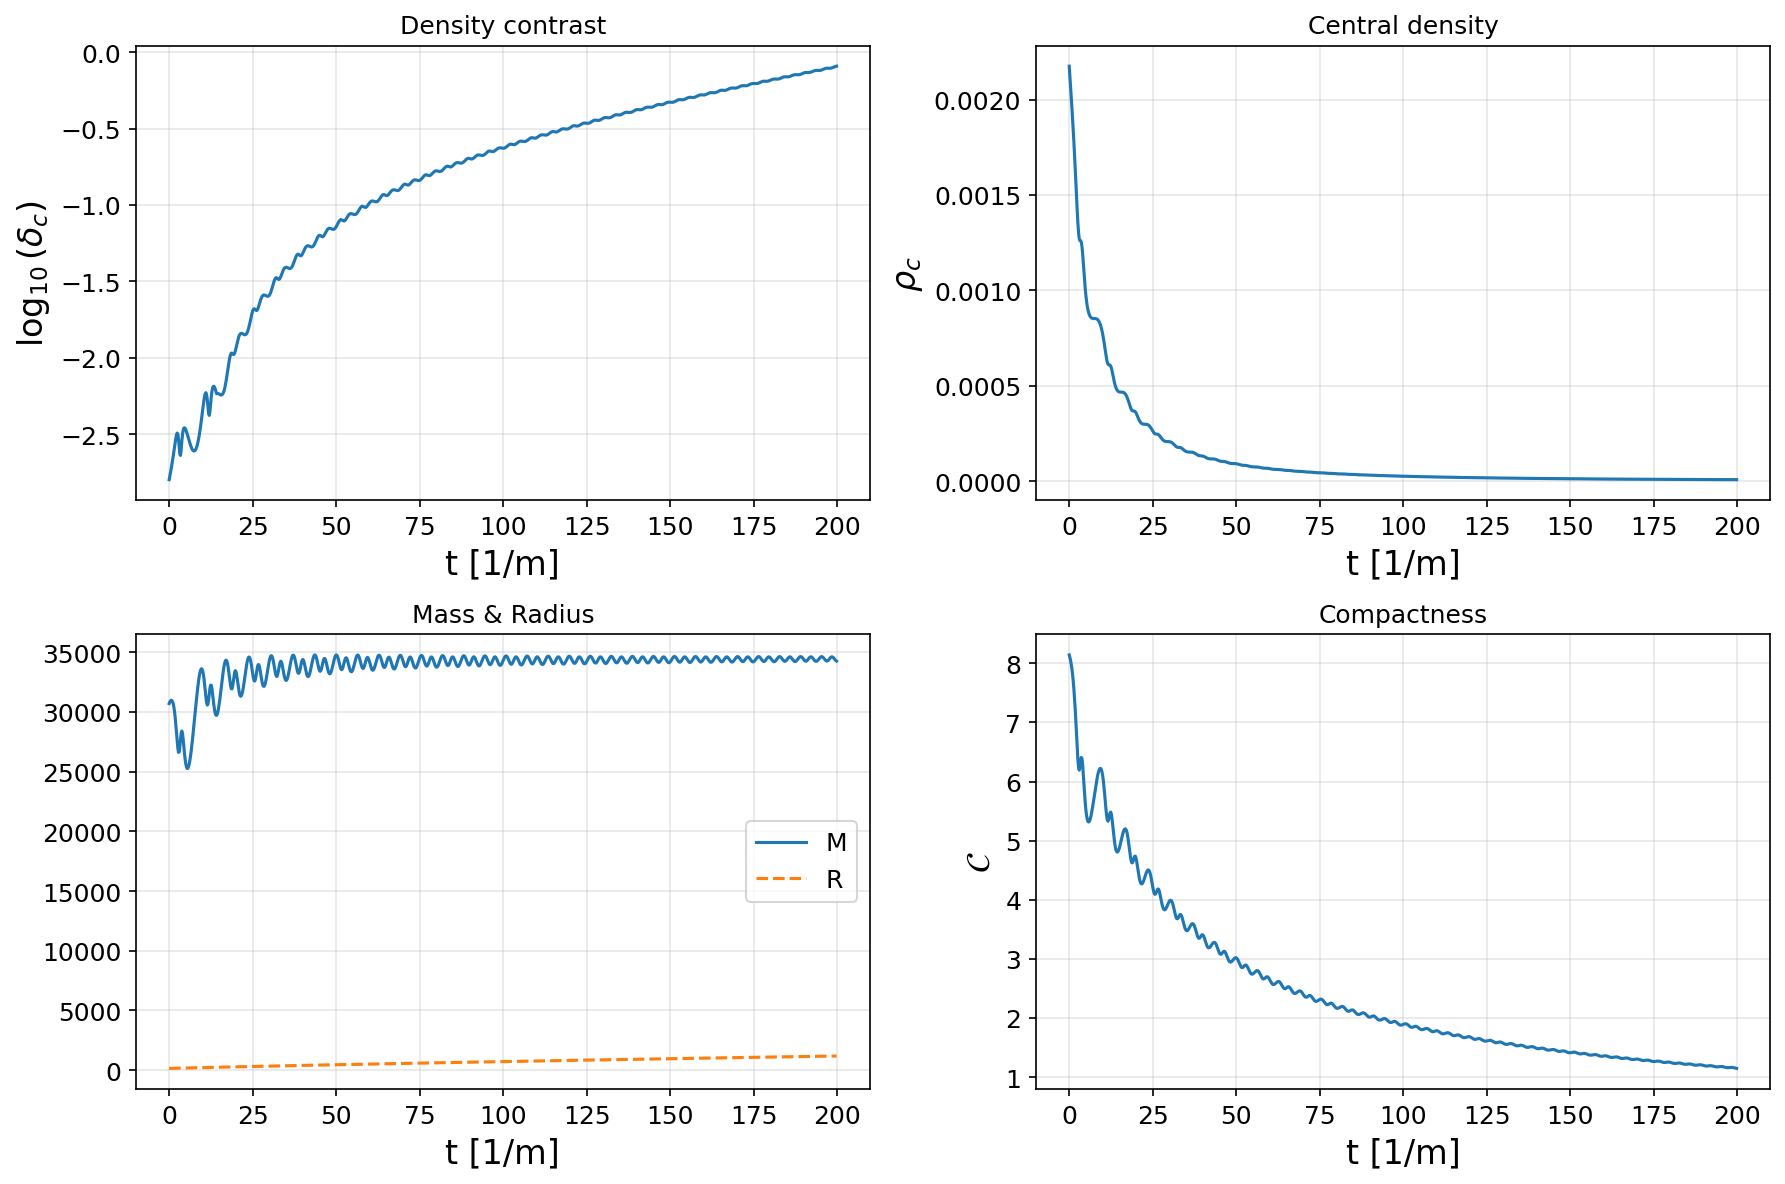

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)

axes[0,0].plot(t, np.log10(np.maximum(delta_c, 1e-30)))
axes[0,0].set(xlabel="t [1/m]", ylabel=r"$\log_{10}(\delta_c)$", title="Density contrast")

axes[0,1].plot(t, rho_c)
axes[0,1].set(xlabel="t [1/m]", ylabel=r"$\rho_c$", title="Central density")

axes[1,0].plot(t, mass, label="M")
axes[1,0].plot(t, radius, label="R", ls="--")
axes[1,0].set(xlabel="t [1/m]", title="Mass & Radius")
axes[1,0].legend()

axes[1,1].plot(t, compactness)
axes[1,1].set(xlabel="t [1/m]", ylabel=r"$\mathcal{C}$", title="Compactness")

for ax in axes.flat:
    ax.grid(True, alpha=0.3)
plt.show()

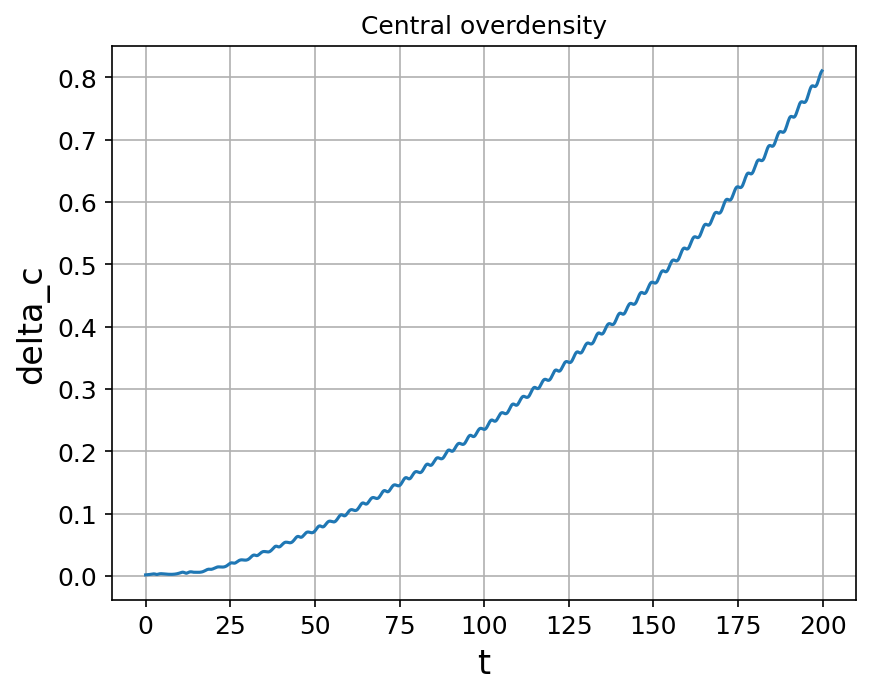

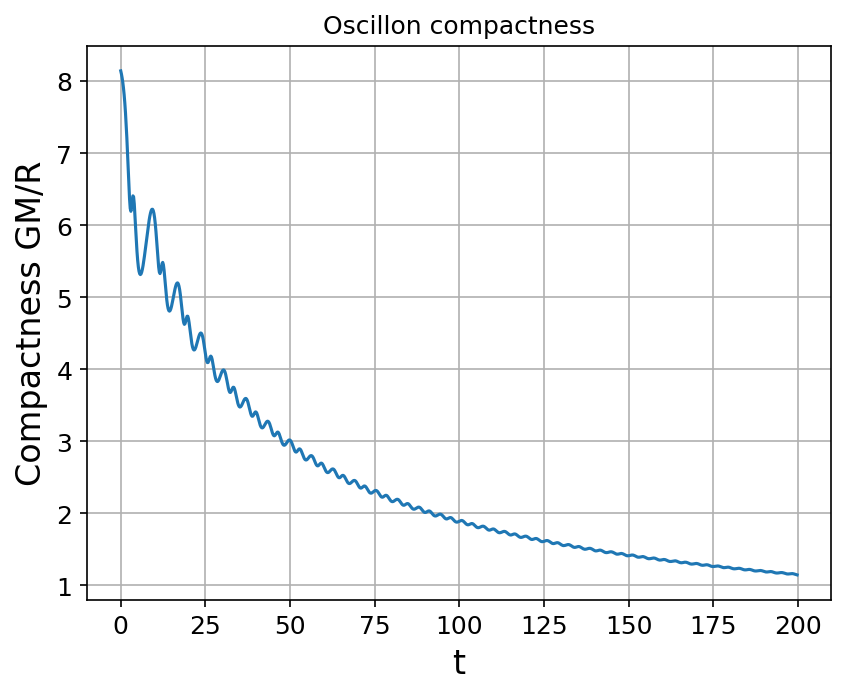

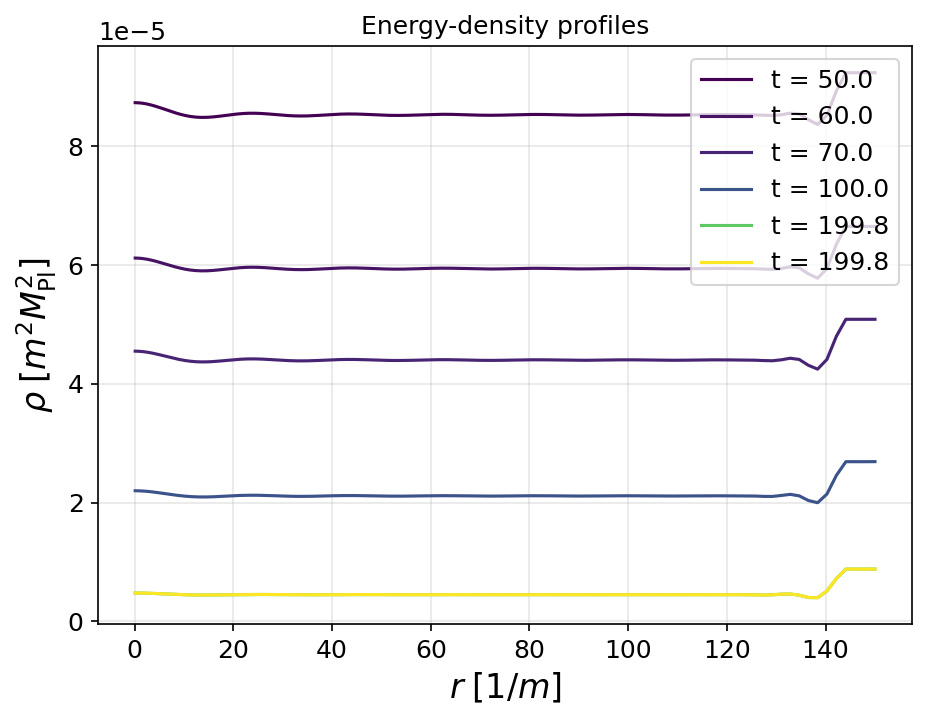

In [19]:
# ---- TIME EVOLUTION PLOTS ----
plt.figure()
plt.plot(osc["t"], delta_c)
plt.xlabel("t")
plt.ylabel("delta_c")
plt.title("Central overdensity")
plt.grid()
plt.show()

plt.figure()
plt.plot(osc["t"], compactness)
plt.xlabel("t")
plt.ylabel("Compactness GM/R")
plt.title("Oscillon compactness")
plt.grid()
plt.show()
'''
plt.figure()
plt.plot(osc["t"], mass, label="M")
plt.plot(osc["t"], radius, label="R")
plt.xlabel("t")
plt.title("Mass and areal radius")
plt.legend(loc=2)
plt.grid()
plt.show()
'''

# ---- OPTIONAL: DENSITY PROFILES AT SELECTED TIMES ----
plot_density_profiles_at_times(osc, times=[50,60, 70, 100, 200, 250])
plt.legend(loc=1)
plt.show()

# Floquet Analysis

Finite MU entries: 120 out of 2100


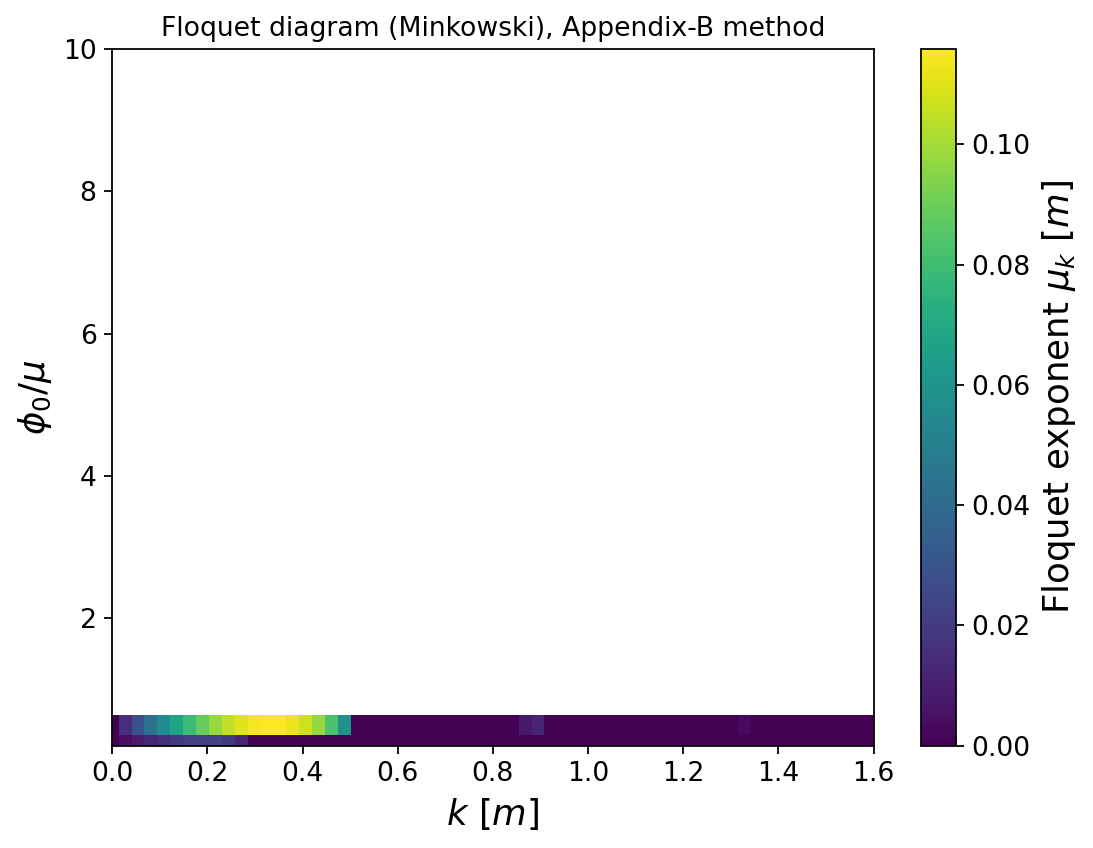

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, quad
from scipy.optimize import root_scalar

# ============================================================
# Floquet diagram (Minkowski) for:
#   V(φ) = (m^2 μ^2 / 2) * (1 - exp(φ/μ))^2
#
# Appendix-B method (paper):
# 1) Period from energy integral:
#    T = 2 ∫_{φmin}^{φmax} dφ / sqrt(2V(φmax) - 2V(φ))
# 2) Integrate two ICs for perturbations over [0,T]
# 3) Build o_k^± and μ_k from ln|o_k^±| / T
# ============================================================

# -------- parameters --------
m = 1.0
mu = 0.1
k_max = 1.6

Ny, Nk = 35, 60
phi_over_mu_min = 0.2
phi_over_mu_max = 10.0

BG_RTOL, BG_ATOL = 1e-9, 1e-11
MODE_RTOL, MODE_ATOL = 1e-8, 1e-10

def safe_exp(x):
    return np.exp(np.clip(x, -200.0, 200.0))

# -------- potential and derivatives --------
def V(phi):
    x = safe_exp(phi/mu)
    return 0.5 * m*m * mu*mu * (1.0 - x)**2

def dV(phi):
    x = safe_exp(phi/mu)
    return m*m * mu * (x*x - x)

def ddV(phi):
    x = safe_exp(phi/mu)
    return m*m * (2.0*x*x - x)

# -------- background (Minkowski): φ¨ + V'(φ)=0 --------
def bg_rhs(t, y):
    phi, phidot = y
    return [phidot, -dV(phi)]

def find_turning_point_negative(phi_max):
    """
    Find φ_min < 0 such that V(φ_min) = V(φ_max) (same energy turning point).
    Uses bracketing + root finding on the negative side.
    """
    E = V(phi_max)

    def f(phi):
        return V(phi) - E

    # Start bracketing on negative side: [a, b] with a << 0 and b = 0
    b = 0.0
    fb = f(b)  # should be <= 0 because V(0)=0 and E>0
    if fb > 0:
        # This would be weird for this potential with φ_max>0, but handle anyway
        raise RuntimeError("Failed to bracket: f(0) > 0 unexpectedly.")

    # Expand a negatively until f(a) > 0 (since V grows for large negative φ here)
    a = -abs(phi_max) - 1e-6
    for _ in range(80):
        fa = f(a)
        if fa > 0:
            break
        a *= 2.0  # go more negative
    else:
        raise RuntimeError("Could not bracket φ_min on the negative side.")

    sol = root_scalar(f, bracket=[a, b], method="brentq", xtol=1e-12, rtol=1e-12)
    return sol.root

def period_from_energy_integral(phi_max):
    """
    Appendix B eq. (B.2):
      T = 2 ∫_{φmin}^{φmax} dφ / sqrt(2V(φmax) - 2V(φ))
    """
    phi_min = find_turning_point_negative(phi_max)
    E = V(phi_max)

    def integrand(phi):
        val = 2.0*(E - V(phi))
        # Guard against tiny negative due to rounding at endpoints
        return 1.0 / np.sqrt(max(val, 0.0) + 1e-30)

    # quad handles endpoint integrable singularities reasonably well
    I, _ = quad(integrand, phi_min, phi_max, epsabs=1e-11, epsrel=1e-9, limit=400)
    T = 2.0 * I
    return T, phi_min

def background_solution_over_period(phi0, T, max_step=0.05):
    """
    Integrate background from 0 to T to get phi(t) for ddV(phi(t)).
    """
    y0 = [phi0, 0.0]
    sol = solve_ivp(
        bg_rhs, (0.0, T), y0,
        rtol=BG_RTOL, atol=BG_ATOL,
        dense_output=True,
        max_step=max_step
    )
    return sol

# -------- Floquet exponent (Appendix B eqs. B.3-B.4) --------
def floquet_mu_appendixB(sol_bg, T, k):
    """
    Integrate two fundamental solutions of the mode equation over one period,
    then compute o_k^± and μ_k = (1/T) ln|o_k^±| (take the growing one).
    """
    def rhs(t, y):
        # y = [dphi1, dpi1, dphi2, dpi2]
        dphi1, dpi1, dphi2, dpi2 = y
        phi = sol_bg.sol(t)[0]
        Om2 = k*k + ddV(phi)
        return [dpi1, -Om2*dphi1, dpi2, -Om2*dphi2]

    # ICs: (1,0) and (0,1) as in Appendix B
    y0 = [1.0, 0.0, 0.0, 1.0]
    sol = solve_ivp(
        rhs, (0.0, T), y0,
        rtol=MODE_RTOL, atol=MODE_ATOL,
        max_step=0.05
    )

    dphi1_T, dpi1_T, dphi2_T, dpi2_T = sol.y[:, -1]

    # Appendix B eq. (B.4)
    tr_half = 0.5 * (dphi1_T + dpi2_T)
    disc = 0.25 * (dphi1_T - dpi2_T)**2 + dphi2_T * dpi1_T
    # Numerical guard
    disc = max(disc, 0.0)

    o_plus  = tr_half + np.sqrt(disc)
    o_minus = tr_half - np.sqrt(disc)

    # Appendix B eq. (B.3): Re[μ] = (1/T) |ln o|
    # For real monodromy eigenvalues: growth if |o|>1, decay if |o|<1, stable if |o|=1.
    mu_plus  = np.log(abs(o_plus)  + 1e-300) / T
    mu_minus = np.log(abs(o_minus) + 1e-300) / T

    return max(0.0, mu_plus, mu_minus)

# -------- grid + compute --------
phi_over_mu = np.linspace(phi_over_mu_min, phi_over_mu_max, Ny)
phi0_grid = phi_over_mu * mu
k_vals = np.linspace(0.0, k_max, Nk)

MU = np.full((Ny, Nk), np.nan)

for i, phi0 in enumerate(phi0_grid):
    # 1) Period from energy integral (Appendix B)
    try:
        T, phi_min = period_from_energy_integral(phi0)
    except Exception:
        continue

    # 2) Background over [0,T]
    sol_bg = background_solution_over_period(phi0, T)

    # 3) Floquet exponent from monodromy eigenvalues
    for j, k in enumerate(k_vals):
        MU[i, j] = floquet_mu_appendixB(sol_bg, T, k)

finite = np.isfinite(MU).sum()
print("Finite MU entries:", finite, "out of", MU.size)

# -------- plot --------
fig, ax = plt.subplots(figsize=(7.0, 5.4), dpi=160)
K, PHI = np.meshgrid(k_vals, phi_over_mu)
MU_plot = np.ma.masked_invalid(MU)

pc = ax.pcolormesh(K, PHI, MU_plot, shading="auto")
ax.set_xlabel(r"$k\ [m]$")
ax.set_ylabel(r"$\phi_0/\mu$")
ax.set_title(r"Floquet diagram (Minkowski), Appendix-B method")
ax.set_xlim(0, k_max)
ax.set_ylim(phi_over_mu_min, phi_over_mu_max)

cbar = fig.colorbar(pc, ax=ax)
cbar.set_label(r"Floquet exponent $\mu_k\ [m]$")

plt.tight_layout()
plt.show()
